# Detecção de Fraude em transações

Nesse projeto iremos criar um modelo de certa classificar se uma compra é fraude ou não é. O Brasil é o segundo país da America Latina de ocorrencia de fraude, segundo um levantamento feito pela Visa, criando um problema para bancos e agencias de cartões de creditos. 

Das fraudes, a dó cartão de credito necessita solução curto prazo para tentar evitar perdas maiores, tanto para o consumidor quanto para a instituição. Podendo tambem ocorrer compras que se passam como normal porem é uma compra fraudada, o falso negativo.

O aprendizado de maquina pode auxiliar nessa etapa de classificação, podendo evitar perdas de milhoes de reais ao ano, com uma simples modelageem.

# Conjunto de Dados

O conjunto de dados utilizado foi obito pelo site do kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud) contendo transações de dois dias, com 492 fraudes do total de 284,807 transações. As colunas dentro desse conjunto de dados são o tempo da transação em segundos, a quantidade de dinheiro utilizado na transação, 28 colunas devido a confidencialidade foram descaracterizados utilizando a transformação PCA (permitindo uma redução de dimensão mantendo o possivel de informação - https://www.dezyre.com/data-science-in-python-tutorial/principal-component-analysis-tutorial).

In [71]:
#Importando as bibliotecas utilizadas no projeto
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import seaborn as sns

# Análise Exploratoria

Olhando para as primeiras linhas conseguimos ver:
A transformação PCA sobre as colunas V1:V28. As colunas Time e Amount estão intactas e as classes são 0 para transação normal e 1 para transação fraudulenta.


In [72]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Com o describe conseguimos ver que a coluna Time e Amount tem uma grande variação entre seu minimo e seu maximo, algoritmos de machine learning trabalham melhor com valores relativamente proximos, por isso vamos ter que fazer uma transformação nessas duas colunas.

In [73]:
print(df.describe())
print('Variação da coluna Amount',min(df.Amount),' até',max(df.Amount))
print('Variação da coluna Time',min(df.Time),' até',max(df.Time))

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.23709

Não temos nenhuma coluna com valores vazios.

In [74]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Fazendo a transformação e retirando Time e Amount do nosso conjunto de dados.

In [75]:
df['Norma_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Norma_Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Amount','Time'],axis =1 ,inplace = True)

Verificando a proporção de transações normais x transações fraudulentas.

Conseguimos notar que as nossas classes estão extremamentes desbalanceadas, por isso não podemos simpplesmente trabalhar com eles dessa forma. Existem algumas formas para se contorna esse problema:
1. A primeira é conseguir mais dados, porém nesse caso não é possivel
2. É fazer o UnderSampling que  diminui a nossa classe majoritaria para valores proximos ao da classe minoritaria, vantagem desse metodo é mais veloz por diminuir o número de linhas, a desvantagem é que nesse processo perde-se informações sobre a classe majoritaria.
3. É fazer o OverSampling que é aumentar a nossa classe minoritaria, um dos metodo é o SMOTE que cria valores artificiais baseados nos dados utilizados https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/. As vantagens que tem muitas informações sobre as duas classes porém tem um tempo mais longo de processamento.


In [76]:
print(round(df["Class"].value_counts()[0]/len(df)*100,2),'% dos dados não é fraude')
print(round(df["Class"].value_counts()[1]/len(df)*100,2),'% dos dados é fraude')

99.83 % dos dados não é fraude
0.17 % dos dados é fraude


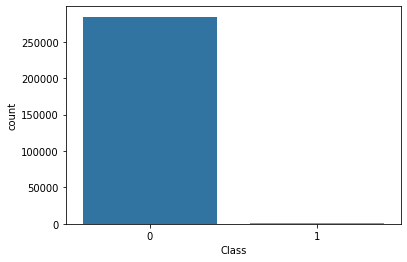

In [77]:
sns.countplot('Class', data=df);

Nesse projeto vamos comparar dois modelos, o UnderSumpling: vamos fazer manualmente porém existe uma biblioteca chamada RandomUnderSampler.


In [78]:
#Vamos transformar o nosso conjunto de dados em 50-50 na classe
Tamanho_Fraude = len(df[df['Class'] == 1])

Indices_F = df[df['Class'] == 1].index
df2 = df.sample(frac=1)

fraud_df = df2.loc[df2['Class'] == 1]
non_fraud_df = df2.loc[df2['Class'] == 0][:Tamanho_Fraude]

df2 = pd.concat([fraud_df, non_fraud_df])


Novo_df = df2.sample(frac=1, random_state=42)

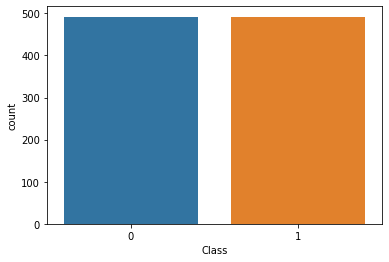

In [79]:
sns.countplot('Class', data=Novo_df);

Vamos analisar as correlações das colunas com a nossa classes.

Inicialmente plotando com os dados originais vemos que não temos uma correlação entre as colunas V1:V28 com a de classes (Figura 1). Depois que diminuimos nosso conjunto de dados, podemos notar uma clara correlação tanto negativa quanto positiva com as classes (Figura 2). 

Como estamos pegando indices aleatorios, seria necessario fazer algumas simulações e depois a media de todos os valores de correlações encontrados para ter os valores mais reais, porém rodando algumas vezes foi perceptivel que os valores são semelhantes.

Temos que as colunas V2,V4 e V11 são positivamente corelacionado com a nossa classe, com isso tem uma maior influencia para descobrir se a transação é uma fraude ou não.

Temos que as colunas V9,V12 e V15 são negativamente corelacionado com a nossa classe, com isso tem uma maior influencia para descobrir se a transação é uma fraude ou não.

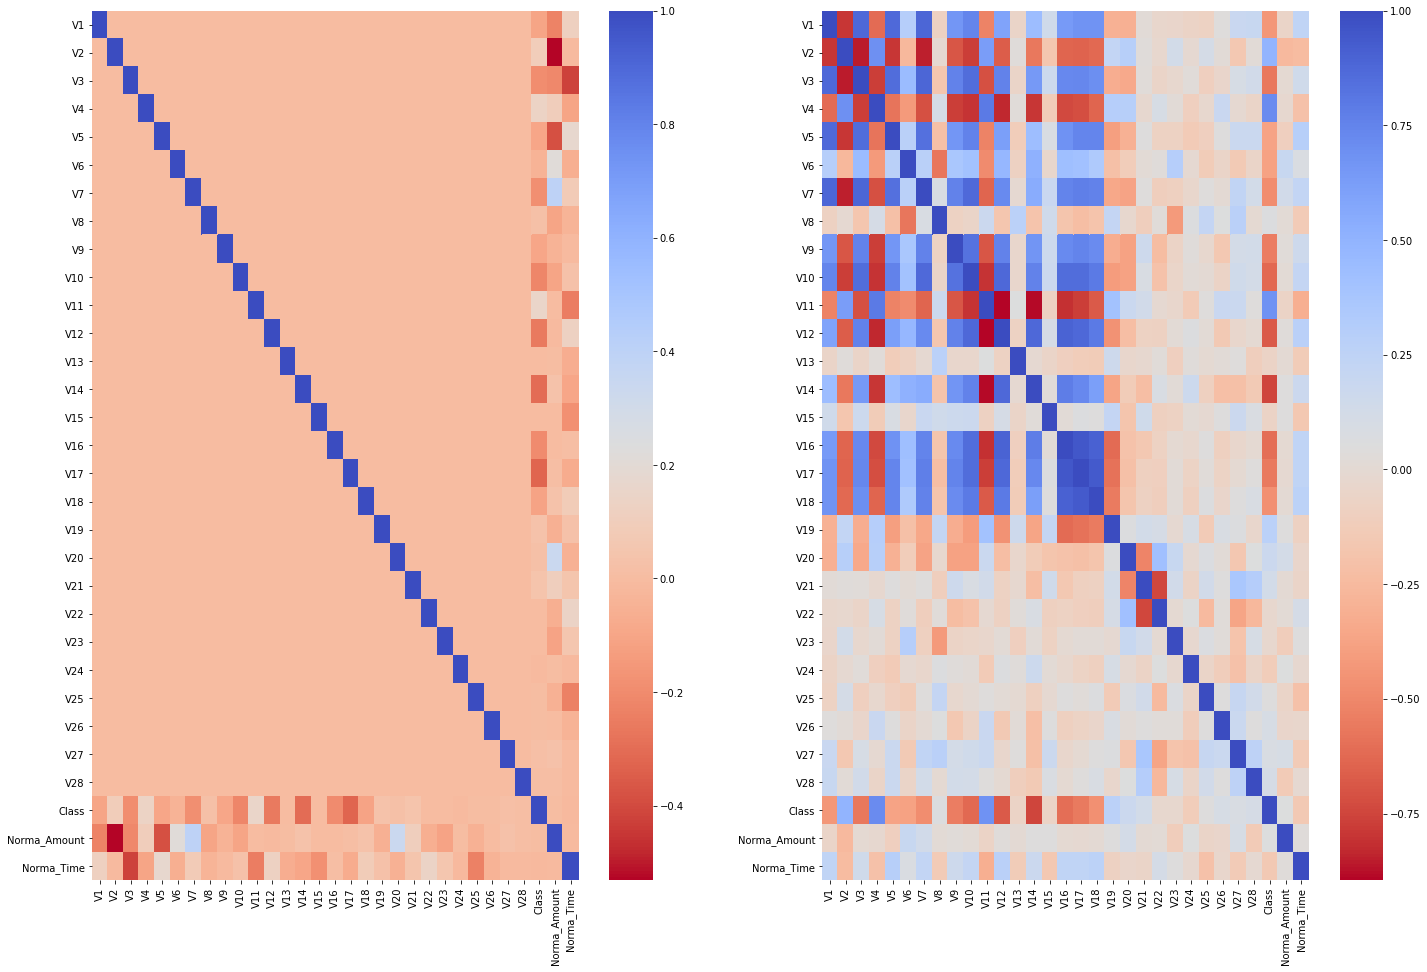

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,16))

sns.heatmap(df.corr(), cmap='coolwarm_r', ax = ax1);

sns.heatmap(Novo_df.corr(), cmap='coolwarm_r', ax = ax2);

Para isso podemos plotar o boxplot de cada coluna e tentar descobrir se existem outliers.

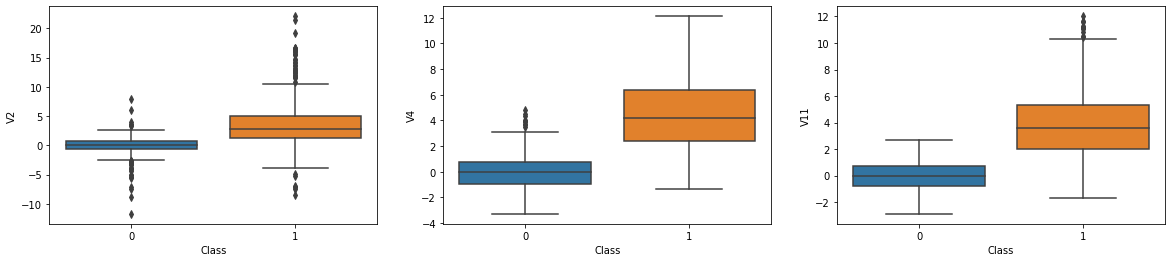

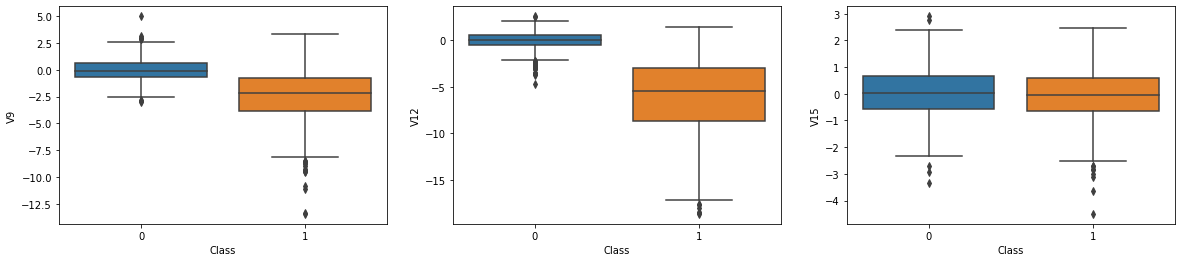

In [81]:
import seaborn as sns

f, axes = plt.subplots(ncols = 3, figsize=(20,4))

sns.boxplot(x="Class",y = "V2", data=Novo_df, ax = axes[0]);
sns.boxplot(x="Class",y = "V4", data=Novo_df, ax = axes[1]);
sns.boxplot(x="Class",y = "V11", data=Novo_df, ax = axes[2]);

f, axes = plt.subplots(ncols = 3, figsize=(20,4))

sns.boxplot(x="Class",y = "V9", data=Novo_df, ax = axes[0]);
sns.boxplot(x="Class",y = "V12", data=Novo_df, ax = axes[1]);
sns.boxplot(x="Class",y = "V15", data=Novo_df, ax = axes[2]);


Para retirar o outliers encontrados (um dado que está fora do padrão), das 6 colunas citadas anteriomentes, foi aplicado a regra de IQR onde é feito a diferença entre o terceiro quartil e o primeiro quartil (IQR), com isso temos o limite inferior  Q1 - IQR*1.5 e o limite superior Q3 - IQR*1.5 todos os valores fora desses limites são retirados do dados. 


In [82]:
#Função para retirada dos pontos, onde passa a coluna, o conjunto de dados e qual classe vai ser.
def Taking_out_Out(Name_colum,datas, value_cla):
    
  V_fraud = datas[Name_colum].loc[datas['Class'] == value_cla].values

  Q1 = np.quantile(V_fraud,0.25)
  Q3 = np.quantile(V_fraud,0.75)
  IQR = Q3 - Q1

  Out_lower = Q1 - IQR*1.5
  Out_upper = Q3 + IQR*1.5

  tes = datas.drop(datas[(datas[Name_colum] < Out_lower) | (datas[Name_colum] > Out_upper)].index)
  return tes

In [83]:
Novo_df = Taking_out_Out('V2',Novo_df,1)
Novo_df = Taking_out_Out('V4',Novo_df,1)
Novo_df = Taking_out_Out('V11',Novo_df,1)
Novo_df = Taking_out_Out('V9',Novo_df,1)
Novo_df = Taking_out_Out('V12',Novo_df,1)
Novo_df = Taking_out_Out('V15',Novo_df,1)

df = Taking_out_Out('V2',df,1)
df = Taking_out_Out('V4',df,1)
df = Taking_out_Out('V11',df,1)
df = Taking_out_Out('V9',df,1)
df = Taking_out_Out('V12',df,1)
df = Taking_out_Out('V15',df,1)

Aqui podemos ver o resultado dos nosso boxplots após retirar os dados.

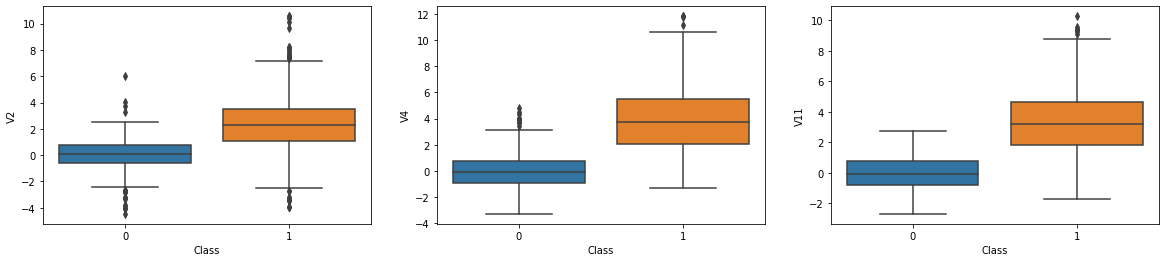

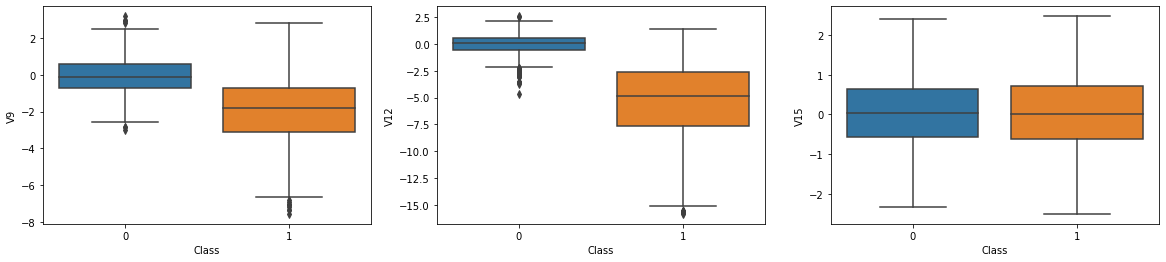

In [84]:
f, axes = plt.subplots(ncols = 3, figsize=(20,4))

sns.boxplot(x="Class",y = "V2", data=Novo_df, ax = axes[0]);
sns.boxplot(x="Class",y = "V4", data=Novo_df, ax = axes[1]);
sns.boxplot(x="Class",y = "V11", data=Novo_df, ax = axes[2]);
f, axes = plt.subplots(ncols = 3, figsize=(20,4))

sns.boxplot(x="Class",y = "V9", data=Novo_df, ax = axes[0]);
sns.boxplot(x="Class",y = "V12", data=Novo_df, ax = axes[1]);
sns.boxplot(x="Class",y = "V15", data=Novo_df, ax = axes[2]);

Limpamos as colunas com maior correlação, agora vamos separar nossos dados em dados de treino e testes.

In [85]:
X = Novo_df.drop('Class',axis = 1)
y = Novo_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.3, random_state = 0)

Vamos utilizar 4 modelos de machine learning para fazer a classificação: Regressão Logistica, K Nearest Neighbor, SVC e arvore de decisão.

Passando as quatro metricas, lembrando alguns detalhes True Positive (TP) são as classificações certas da classe Positiva, False positive (FP) é uma classificação errada da classe positiva, True Negative (TN) são as classificações certas da classe negativa e False Negativa (FN) são as classificações erradas da classe negativa visto pela Figura abaixo.

<img src=https://miro.medium.com/max/1780/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg  width="400"/>

1. Acuracia - Seria a Precisão do Modelo de maneira geral que é dada por $\frac{TP + TN}{TP + TN + FP + FN}$


2. Precisão - É o número de vezes que a classe Positivo foi classificada corretamente dividido pelo número de classes classificadas como Positivo $\frac{TP}{TP + FP}$ pode ser visto
<img src=https://miro.medium.com/max/875/1*PULzWEven_XAZjiMNizDCg.png  width="400"/>

3. Recall - É o  número de vezes que a classe Positivo foi predita corretamente dividido pelo número de classes Positivo que contém no dado de teste $\frac{TP}{TP + FN}$
<img src = https://miro.medium.com/max/875/1*BBhWQC-m0CLN4sVJ0h5fJQ.jpeg width = "400"/>


4. F1 - É utilizado quando se quer um balanceamento entre as metricas de precisão e recall ${2*}\frac{Precision * Recall}{Precision + Recall}$

Construimos um DataFrame com as quatro metricas para verificar a avaliação dos nossos modelos sem inicialmente fazer uma calibração dos modelos. Com isso temos que o modelo de Regressão logistica e SVC foram os melhores nas avaliações.

In [86]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

Precision = []
Accuracy = []
Recall = []
f1 = []
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    
    training_score1 = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'accuracy')
    Accuracy.append(training_score1.mean())
    
    training_score2 = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'recall')
    Recall.append(training_score2.mean())
    
    training_score3 = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'precision')
    Precision.append(training_score3.mean())
    
    training_score4 = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'f1')
    f1.append(training_score4.mean())
    
    #print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Data_Metrics = pd.DataFrame({'Accuracy':Accuracy,'Precision':Precision,'Recall':Recall,'f1':f1}, 
                            index = ["Logistic",'Knearest','SVC','Decision Tree'])

Data_Metrics

,Accuracy,Precision,Recall,f1
Logistic,0.931917,0.958337,0.887273,0.920696
Knearest,0.923826,0.979461,0.847273,0.908008
SVC,0.925479,0.987628,0.843636,0.908958
Decision Tree,0.894663,0.887486,0.887273,0.886766


Para o nosso problema a acuracia não é a metrica ideal para ser analisada, pois um caso de  transação normal classificada como fraude não é ruim como uma transação fraudulenta classificada como normal, nesse caso onde ocorre a perda de dinheiro.

O Recall é a metrica que vamos utilizar pois utiliza os acertos e os erros na classificação de fraudes. Outra metrica que podemos avaliar é a AUC (Area Under the Curve) derivado de ROC (Receiver Operating Characteristic) que traça “True Positive Rate vs. False Positive Rate” e AUC é a medida de separabilidade, resumindo essa metrica diz o quão bem seu modelo está conseguindo distinguir as classes (https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

Com a função de GridSearchCv, focado para o recall, para estimar os melhores parametros para o nosso modelo e verificar a melhoria nas metricas

In [87]:
#Definindo o range dos parametros.
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr = LogisticRegression(solver='liblinear',max_iter=  1000)

knears_params = {"n_neighbors": list(range(2,20,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
Kr = KNeighborsClassifier()

svc_params = {'C': [0.001,0.01,0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1,10,100],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(1,15,1)), 
            "min_samples_leaf": list(range(1,17,1))}

#Rodando a função
grid_Log = GridSearchCV( lr,log_reg_params,cv = 5,scoring = 'recall')
grid_Log.fit(X_train, y_train)

grid_Kr = GridSearchCV( Kr,knears_params,cv = 5,scoring = 'recall')
grid_Kr.fit(X_train, y_train)

grid_svc = GridSearchCV(SVC(), svc_params,scoring = 'recall')
grid_svc.fit(X_train, y_train)

grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params,scoring = 'recall')
grid_tree.fit(X_train, y_train)

C:\Users\gusta\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\gusta\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

Com .best_estimator_ temos os melhores valores de parametros e podemos repetir o processo novamente para verificar o quanto nos modelos melhoraram.

Podemos ver que a acuracia dos quatro modelo decairam assim como a precisão, porem como esperado o Recall aumentou bastante para os modelos de regressão logistica e SVM, por isso vamos focar nesses dois modelos para fazer a matrix de confusão e a metrica AUC.

In [88]:
Estimators = {'Log':grid_Log.best_estimator_,'KNN':grid_Kr.best_estimator_,'SVC':grid_svc.best_estimator_,'DecisionT':grid_tree.best_estimator_}

Precision_grid = []
Accuracy_grid = []
Recall_grid = []
f1_grid = []

for key, est in Estimators.items():
    
    training_score1 = cross_val_score(est, X_train, y_train, cv=5, scoring = 'accuracy')
    Accuracy_grid.append(training_score1.mean())
    
    training_score2 = cross_val_score(est, X_train, y_train, cv=5, scoring = 'recall')
    Recall_grid.append(training_score2.mean())
    
    training_score3 = cross_val_score(est, X_train, y_train, cv=5, scoring = 'precision')
    Precision_grid.append(training_score3.mean())
    
    training_score4 = cross_val_score(est, X_train, y_train, cv=5, scoring = 'f1')
    f1_grid.append(training_score4.mean())

Data_Metrics_grid = pd.DataFrame({'Accuracy':Accuracy_grid,'Precision':Precision_grid,'Recall':Recall_grid,'f1':f1_grid}, 
                            index = ["Logistic",'Knearest','SVC','Decision Tree'])

Data_Metrics_grid

,Accuracy,Precision,Recall,f1
Logistic,0.726069,0.628105,0.949091,0.755674
Knearest,0.925479,0.963630,0.865455,0.911625
SVC,0.873512,0.804376,0.949091,0.870304
Decision Tree,0.914110,0.903489,0.901818,0.892522


In [89]:
grid_Log.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Escolhendo os dois melhores modelos para trabalhar, vamos colocar em produção com os dados de teste e fazer as matrizes de confusão para analisar o resultado.

A regressão logistica deu um valor mais satisfatorio em geral, enquanto o SVM deu um valor maior de recall porem o falso positivo deu baixo, mostrando que quando um aumenta o outro diminui, por isso temos que escolher uma das opçoes.

Quando calculamos o AUC vemos que os dois modelos estão proximos na indentificação.

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       136
           1       0.91      0.95      0.93       129

    accuracy                           0.93       265
   macro avg       0.93      0.93      0.93       265
weighted avg       0.93      0.93      0.93       265
               precision    recall  f1-score   support

           0       0.95      0.75      0.84       136
           1       0.78      0.96      0.86       129

    accuracy                           0.85       265
   macro avg       0.87      0.86      0.85       265
weighted avg       0.87      0.85      0.85       265



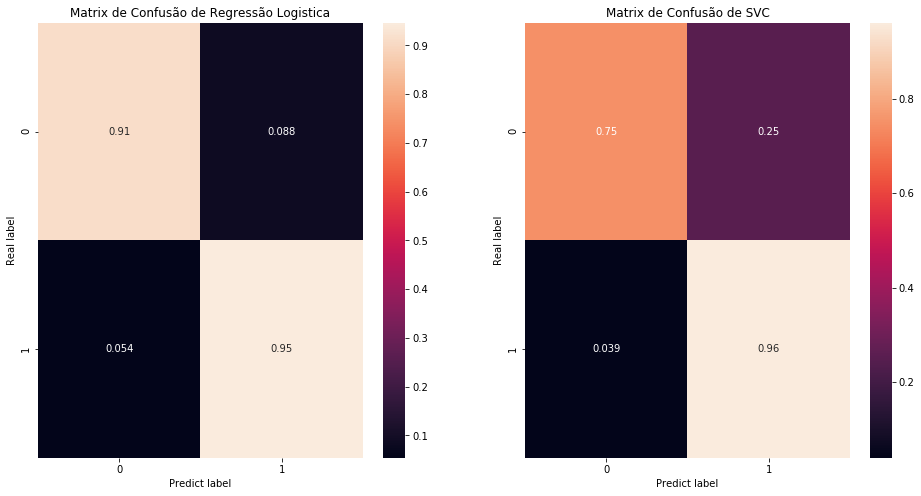

AUC score for Logistic: 0.92875056999544
AUC score for SVC: 0.8556201550387597


In [90]:
from sklearn.metrics import roc_auc_score, roc_curve

y_predicao_Logist = grid_Log.predict(X_test)
cnf_matrix_Logist = confusion_matrix(y_test,y_predicao_Logist,normalize= 'true')
#print (classification_report(y_test, y_predicao_Logist))



y_predicao_SVC = grid_svc.predict(X_test)
cnf_matrix_SVC = confusion_matrix(y_test,y_predicao_SVC,normalize= 'true')

print (classification_report(y_test, y_predicao_Logist),classification_report(y_test, y_predicao_SVC))

labels = [0,1]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
#ax = fig.add_subplot(111)
sns.heatmap(cnf_matrix_Logist, annot = True, ax = ax1)
sns.heatmap(cnf_matrix_SVC, annot = True, ax = ax2)

ax1.title.set_text('Matrix de Confusão de Regressão Logistica')
ax1.set_xlabel('Predict label')
ax1.set_ylabel('Real label')

ax2.title.set_text('Matrix de Confusão de SVC')
ax2.set_xlabel('Predict label')
ax2.set_ylabel('Real label')
#plt.title('Matrix de Confusão')
plt.show()

print("AUC score for Logistic:",roc_auc_score(y_test, y_predicao_Logist))
print("AUC score for SVC:",roc_auc_score(y_test, y_predicao_SVC))

Repetimos o processo de calibração mas agora vamos calibrar para acuracia, o valor de AUC melhorou porém oque melhorou foram as classificações erradas em relação a transações normais que estavam sendo classificadas como fraudes, consequentemente diminuindo a nossa metrica de recall.

C:\Users\gusta\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


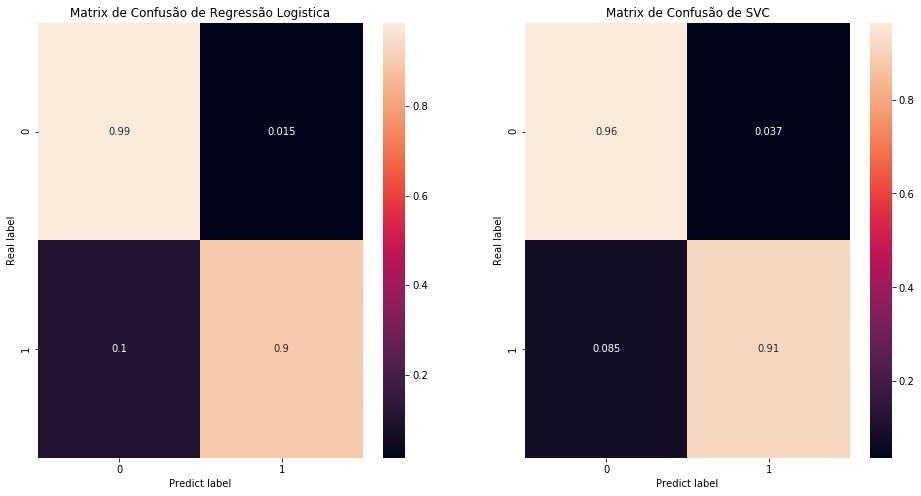

AUC score for Logistic: 0.9422594619243047
AUC score for SVC: 0.9389819881440947


In [91]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr = LogisticRegression(solver='liblinear',max_iter=  1000)


grid_Log2 = GridSearchCV( lr,log_reg_params,cv = 5)
grid_Log2.fit(X_train, y_train)


svc_params = {'C': [0.001,0.01,0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1,10,100],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc2 = GridSearchCV(SVC(), svc_params,)
grid_svc2.fit(X_train, y_train)

y_predicao_Logist2 = grid_Log2.predict(X_test)
y_predicao_SVC2 = grid_svc2.predict(X_test)

cnf_matrix_Logist2 = confusion_matrix(y_test,y_predicao_Logist2,normalize= 'true')
cnf_matrix_SVC2 = confusion_matrix(y_test,y_predicao_SVC2,normalize= 'true')

labels = [0,1]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
#ax = fig.add_subplot(111)
sns.heatmap(cnf_matrix_Logist2, annot = True, ax = ax1)
sns.heatmap(cnf_matrix_SVC2, annot = True, ax = ax2)

ax1.title.set_text('Matrix de Confusão de Regressão Logistica')
ax1.set_xlabel('Predict label')
ax1.set_ylabel('Real label')

ax2.title.set_text('Matrix de Confusão de SVC')
ax2.set_xlabel('Predict label')
ax2.set_ylabel('Real label')
#plt.title('Matrix de Confusão')
plt.show()

print("AUC score for Logistic:",roc_auc_score(y_test, y_predicao_Logist2))
print("AUC score for SVC:",roc_auc_score(y_test, y_predicao_SVC2))

# Conclusão


Para concluir temos que o melhor modelo para quando fazemos a diminuição dos dados foi a Regressão Logistica com os parametros ${C = 0.01 e Penalty = l1}$ com valores satisfatorios.

Vale lembrar tambem que o mais correto nesse caso é simular para diferentes iterações, pois como estamos utilizando dados aleatorios precisamos conseguir reunir o maximo de informações possiveis, e tirar uma media dos resultados.

Uma proxima analise é utilizar o metodo SMOTE e comparar resultados.